In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit.extensions.unitary import UnitaryGate
from qiskit.circuit.library.standard_gates import CZGate
from qiskit.circuit.library.standard_gates import CHGate
from qiskit.circuit.library.standard_gates import CRYGate
from qiskit.circuit.library.standard_gates import HGate
from qiskit.circuit.library.standard_gates import XGate
from qiskit.circuit.library.standard_gates import RXGate
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.circuit.library.standard_gates import RZGate

from qiskit.quantum_info import Statevector

from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
def createEqSuperposCollectiveU():
    temp = QuantumCircuit(5)
    
    temp.ry(2*np.arctan(1/np.sqrt(2)), 1)
    temp.x(1)
    temp.append(CHGate(), [1, 0])
    temp.x(1)
    
    temp.ry(np.pi/3, 2)
    temp.x(2)
    temp.append(CRYGate(2*np.arctan(1/np.sqrt(2))), [2, 3])
    temp.x(3)
    temp.append(HGate().control(2), [2, 3, 4])
    temp.x(2)
    temp.x(3)
    
    return temp

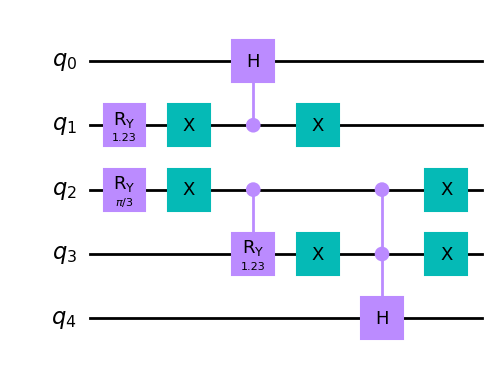

In [3]:
createEqSuperposCollectiveU().draw('mpl')

In [4]:
backend = Aer.get_backend('statevector_simulator')
result = execute(createEqSuperposCollectiveU().reverse_bits(), backend).result().get_statevector()
for i in range(len(result)):
    if np.abs(result[i])>=1e-6:
        print(i, result[i])

0 (0.28867513459481287+1.070737396870758e-16j)
1 (0.288675134594813+1.0707373968707583e-16j)
2 (0.2886751345948129+3.204937810639273e-17j)
4 (0.28867513459481275+2.0345189474585947e-16j)
8 (0.28867513459481287+1.3877787807814457e-16j)
9 (0.288675134594813+1.3877787807814457e-16j)
10 (0.28867513459481287+2.7755575615628914e-17j)
12 (0.2886751345948128+2.0816681711721685e-16j)
16 (0.28867513459481287+1.9034046653396258e-16j)
17 (0.288675134594813+1.9034046653396258e-16j)
18 (0.28867513459481287+1.153161049532795e-16j)
20 (0.28867513459481275+2.5896304597711735e-16j)


In [5]:
def Bx():
    temp = QuantumCircuit(2)
    temp.append(RXGate(-np.pi/2), [0])
    temp.append(RXGate(-np.pi/2), [1])
    return temp

In [6]:
def By():
    temp = QuantumCircuit(2)
    temp.append(RYGate(-np.pi/2), [0])
    temp.append(RYGate(-np.pi/2), [1])
    return temp

In [7]:
def Bz():
    temp = QuantumCircuit(2)
    temp.append(RZGate(-np.pi/2), [0])
    temp.append(RZGate(-np.pi/2), [1])
    return temp

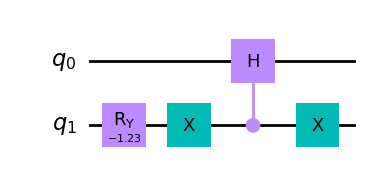

In [55]:
#Unitary to create state \rho
size = 2
state = QuantumCircuit(size)
#state.h(0)
#state.cx(0, 1)
#state.z(0)
#state.x(1)

state.ry(2*np.arctan(-1/np.sqrt(2)), 1)
state.x(1)
state.append(CHGate(), [1, 0])
state.x(1)


state.draw('mpl')

In [57]:
backend = Aer.get_backend('statevector_simulator')
result = execute(state.reverse_bits(), backend).result().get_statevector()
for i in range(len(result)):
    if np.abs(result[i])>=1e-6:
        print(i, result[i])

0 (0.5773502691896257-1.1102230246251565e-16j)
1 (-0.5773502691896257+1.3877787807814457e-16j)
2 (0.5773502691896257+5.551115123125783e-17j)


In [58]:
def createQuantumCircuit():
    circ = QuantumCircuit(7)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperposCollectiveU()
    circ.append(superPosCircuit, range(5))
    circ.append(state, [5, 6])
    
    circ.append(Bx().control(1), [4, 5, 6])
    circ.append(Bx().control(1), [4, 5, 6])
    
    circ.append(By().control(1), [3, 5, 6])
    circ.append(By().control(1), [3, 5, 6])

    circ.append(Bz().control(1), [2, 5, 6])
    circ.append(Bz().control(1), [2, 5, 6])
    
    circ.append(By().control(1), [1, 5, 6])
    circ.append(Bx().control(1), [1, 5, 6])
    
    circ.append(Bx().control(1), [0, 5, 6])
    circ.append(By().control(1), [0, 5, 6])

    circ.append(superPosCircuit.inverse(), range(5))
    
    return circ

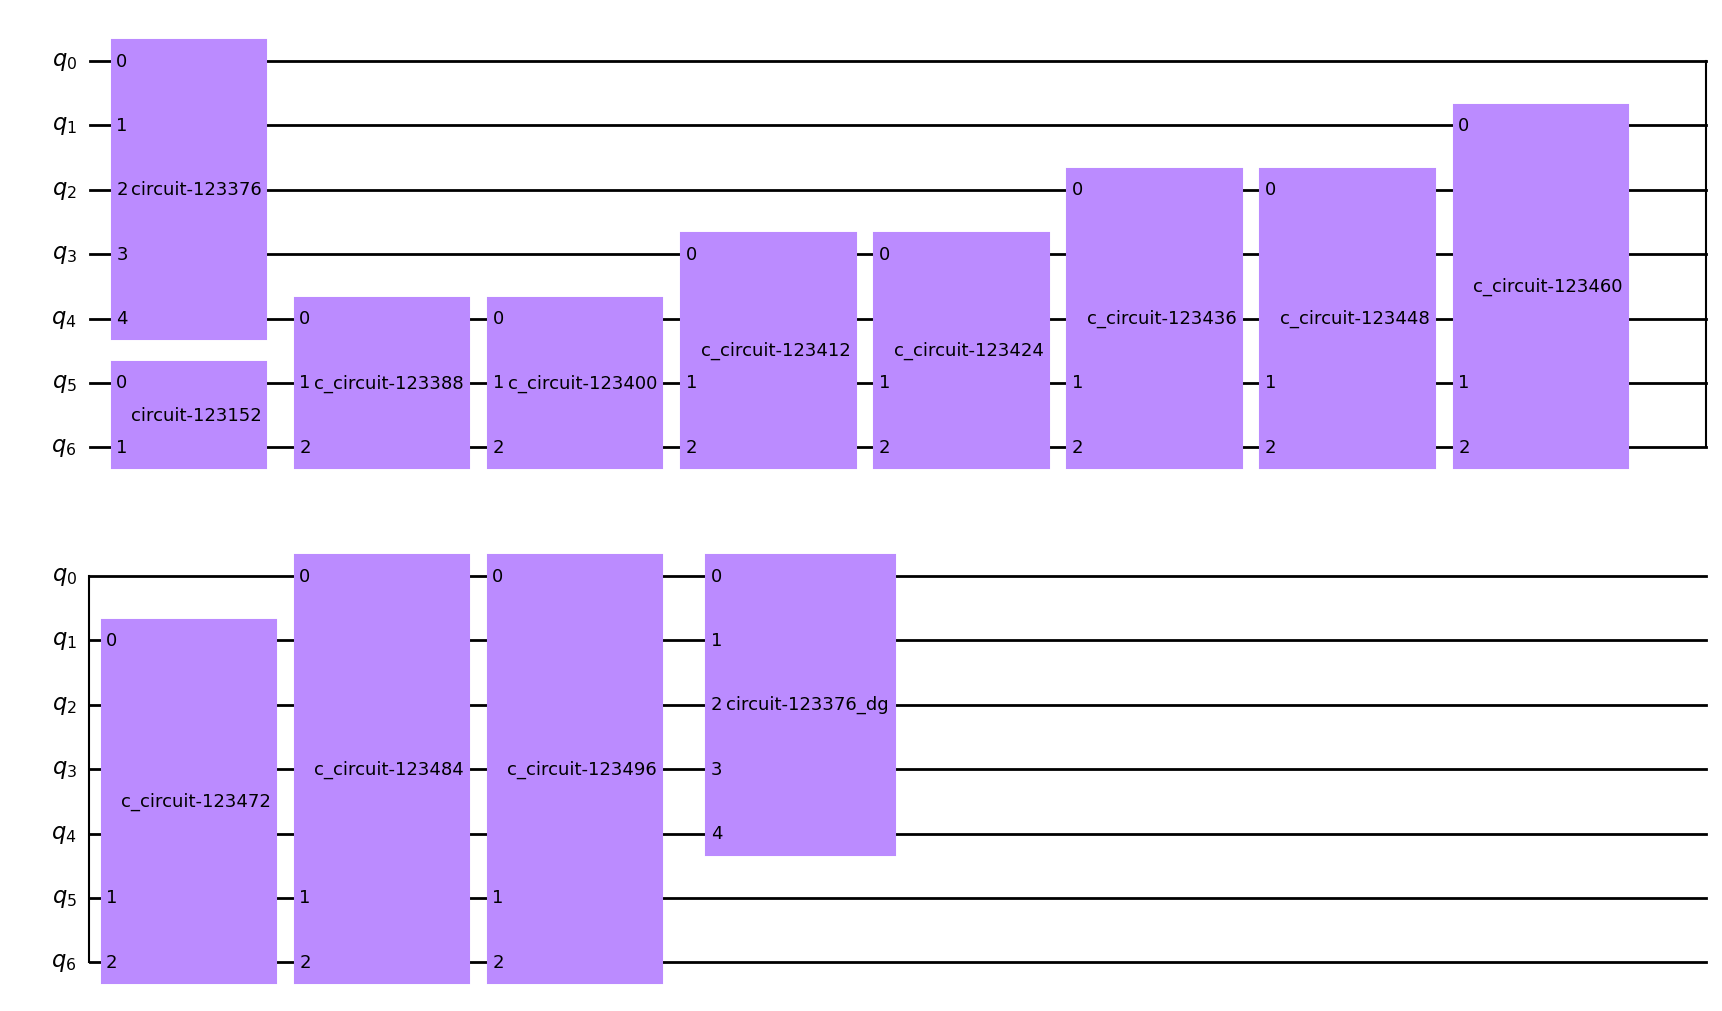

In [59]:
qCirc = createQuantumCircuit()
qCirc.draw('mpl')

In [60]:
#Create Hamiltonian here
hamiltonian = I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [61]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [62]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation. 
'''
#Replace the provider with your personal credentials for hub, group and main
#provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")

noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibm_nairobi")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=20000, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [63]:
def costf(noisy = False):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    
    if noisy:
        result = noisy_sampler.convert(expectation).eval()  
    else:
        result = noiseless_sampler.convert(expectation).eval()  
    
    return np.real(result)

In [65]:
print("Cost : ", costf(False))
print("Cost : ", costf(True))

Cost :  0.6666666666666662
Cost :  0.26609684867018074


In [48]:
provider.backends(filters=lambda x: x.configuration().n_qubits >= 8
                                    and not x.configuration().simulator)

[]